# Recurrent Neural networks
## Vectorization - One-hot encoding or word embeding?
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are many ways we could do that:
- We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as the first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).
- We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as the first layer in our network a Dense layer, capable of handling floating-point vector data.

During lab 2 we used the following solution (no need to run it now):
```python
import numpy as np
 
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
 
# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Vectorize labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
```

Alternatively to the two solutions above, we could use a techniqe called word embeding. It is much more sophisticated method. Mapping words into dictionaries, that we explained before, is usefull only to a certain degree. It treats each word separately and only realy assess the text by checking if a word (or a combination of words) exists. It does not understand the meaning of a word. Furthermore, simmilar words are treated as a separate entries in a dictionary (for example 'run', 'runs', 'running' will be 3 different words). We can use some pre-processing to cut prefixes and suffixes, but it will only work for some words.

What the word embedding tries to achieve is parametrise the meaning of the words - for example map if they are a noun or a verb, assess the tense or a gender, or even specify some more complex categories like object, animal, vehicle etc. What we have to do is specify how many of those parameters we want and then we place each word in an n-dimensional space related to each parameter. Again, the beauty of the neural networks comes from the fact, that we do not need to specify what those parameters are - maybe for one problem we would need to differ if the word is a noun or a verb, and for other problem if it is a dog or cat breed. The network will learn all of it during training. Simmilar to ConvNet filters, we only need to decide how many parameters we want in our Embedding layer. If the embedding is large, the network will better understand nuances between words. But if it is too large, it will compute slow and can lead to overfitting. You probably already noticed some similarities.

![Embedding matrix](images/lesson_9_matrix.png)
![Embedding parameters](images/lesson_9_parameters.png)

Better explanation of word embedding can be found:
- https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
- https://www.tensorflow.org/tutorials/text/word_embeddings

## Introduction to RNN
Recurrent Neural Network is a generalization of a feedforward neural network that has internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input.

Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. In other neural networks all the inputs are independent of each other, but in RNN all the inputs are related to each other.

![Unrolled RNN](images/lesson_9_unrolled_nn.png)

Recurrent networks take as their input not just the current input example they see, but also what they have perceived previously in time. Here’s a diagram of an early, simple recurrent net proposed by Elman, where the BTSXPE at the bottom of the drawing represents the input example in the current moment, and CONTEXT UNIT represents the output of the previous moment.

![Return sequence](images/lesson_9_return_seq.jpg)

### Return_sequences
Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)), or it can return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). These two modes are controlled by the return_sequences constructor argument.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
 
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

2023-12-20 15:51:25.794740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 15:51:25.794764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 15:51:25.794783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 15:51:25.799986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 15:51:26.488051: W tensorflow/compiler/

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [2]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Stacking multiple layers
It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers to return full sequences. In the following example we put together 4 SimpleRNN layers, the last one without parameter `return_sequences=True` as it only returns the last outputs).

Model summary:
```
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
=================================================================
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
```

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328320 (1.25 MB)
Trainable params: 328320 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training a simple RNN
**Task 1:** Let's train a simple recurrent network using an Embedding layer and a SimpleRNN layer. We will use the IMDB movie review classification problem to try the RNN models. First, let's preprocess the data:

In [4]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

#Import IMDB dataset:
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=10000)

#Pad sequences:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=500)
input_test = sequence.pad_sequences(input_test, maxlen=500)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [27]:
import matplotlib.pyplot as plt
def plot_metric(dict, metric):
    plt.clf()  # clear figure
    loss_values = dict[metric]
    val_loss_values = dict[f'val_{metric}']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'go', label=f'Training {metric}')
    plt.plot(epochs, val_loss_values, 'bo', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

Architecture:
- Embedding layer (max_features=10000, 32)
- One or more SimpleRNN - 32
- Dense layer with one neuron and sigmoid activation

Compile:
- rmsprop optimizer,
- binary_crossentropy loss function,
- accuracy metrics.

Train:
- epochs=10,
- batch_size=128,
- validation_split=0.2

In [5]:
# Architecture:
# - Embedding layer (max_features=10000, 32)
# - One or more SimpleRNN - 32
# - Dense layer with one neuron and sigmoid activation
from tensorflow.keras.layers import Dense

model_1 = Sequential()
model_1.add(Embedding(10000, 32))
model_1.add(SimpleRNN(32, return_sequences=True))
model_1.add(SimpleRNN(32, return_sequences=True))
model_1.add(SimpleRNN(32, return_sequences=True))
model_1.add(SimpleRNN(32))
model_1.add(Dense(1, activation='sigmoid'))
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 32835

In [6]:
# Compile:
# - rmsprop optimizer,
# - binary_crossentropy loss function,
# - accuracy metrics.
from tensorflow.keras.optimizers import RMSprop

model_1.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])

In [7]:
# Train:
# - epochs=10,
# - batch_size=128,
# - validation_split=0.2

epochs = 10
batch_size = 128
validation_split = 0.2

model_1.fit(input_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)


Epoch 1/10
157/157 [==============================] - 27s 160ms/step - loss: 0.6686 - acc: 0.5845 - val_loss: 0.5913 - val_acc: 0.6932
Epoch 2/10
157/157 [==============================] - 25s 161ms/step - loss: 0.5196 - acc: 0.7484 - val_loss: 0.4934 - val_acc: 0.7636
Epoch 3/10
157/157 [==============================] - 26s 164ms/step - loss: 0.4014 - acc: 0.8260 - val_loss: 0.4173 - val_acc: 0.8060
Epoch 4/10
157/157 [==============================] - 26s 163ms/step - loss: 0.3323 - acc: 0.8616 - val_loss: 0.3758 - val_acc: 0.8382
Epoch 5/10
157/157 [==============================] - 25s 162ms/step - loss: 0.2875 - acc: 0.8852 - val_loss: 0.3622 - val_acc: 0.8422
Epoch 6/10
157/157 [==============================] - 25s 161ms/step - loss: 0.2566 - acc: 0.8972 - val_loss: 0.3405 - val_acc: 0.8556
Epoch 7/10
157/157 [==============================] - 26s 164ms/step - loss: 0.2305 - acc: 0.9115 - val_loss: 0.3904 - val_acc: 0.8448
Epoch 8/10
157/157 [==============================] - 2

**Expected output:** (about) acc: 0.99, val-acc: 0.8  
Plot the training and validation loss and accuracy:

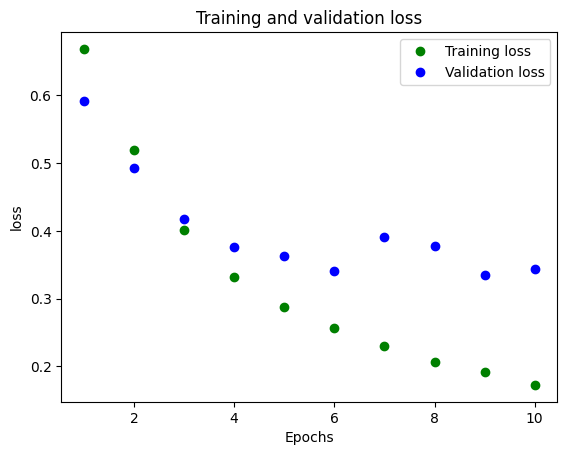

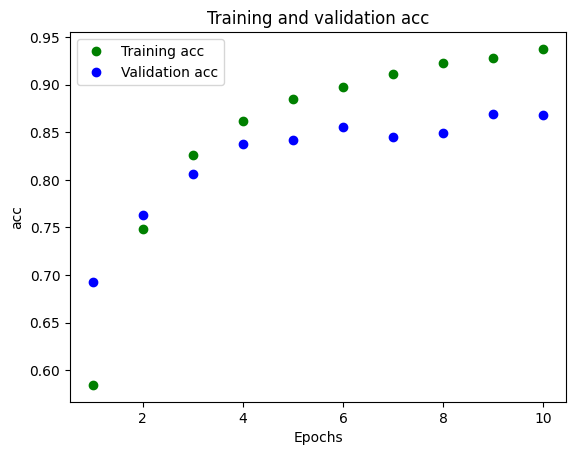

In [17]:
fit_1_dict = model_1.history.history
fit_1_dict.keys()

# Display the loss and accuracy curves on a plot:
plot_metric(fit_1_dict, 'loss')
plot_metric(fit_1_dict, 'acc')

In [23]:
# Compile and train the model with default optimizer 'rmsprop'

model_1_default = Sequential()
model_1_default.add(Embedding(10000, 32))
model_1_default.add(SimpleRNN(32, return_sequences=True))
model_1_default.add(SimpleRNN(32, return_sequences=True))
model_1_default.add(SimpleRNN(32, return_sequences=True))
model_1_default.add(SimpleRNN(32))
model_1_default.add(Dense(1, activation='sigmoid'))
model_1_default.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 32835

In [24]:
model_1_default.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['acc'])

model_1_default.fit(input_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/10
157/157 [==============================] - 27s 162ms/step - loss: 0.6646 - acc: 0.5705 - val_loss: 0.6922 - val_acc: 0.6434
Epoch 2/10
157/157 [==============================] - 25s 158ms/step - loss: 0.4200 - acc: 0.8171 - val_loss: 0.3916 - val_acc: 0.8334
Epoch 3/10
157/157 [==============================] - 25s 159ms/step - loss: 0.3354 - acc: 0.8684 - val_loss: 0.3609 - val_acc: 0.8472
Epoch 4/10
157/157 [==============================] - 25s 158ms/step - loss: 0.2715 - acc: 0.8944 - val_loss: 0.3525 - val_acc: 0.8572
Epoch 5/10
157/157 [==============================] - 25s 160ms/step - loss: 0.2151 - acc: 0.9161 - val_loss: 0.4357 - val_acc: 0.8238
Epoch 6/10
157/157 [==============================] - 25s 159ms/step - loss: 0.1579 - acc: 0.9420 - val_loss: 0.4934 - val_acc: 0.8618
Epoch 7/10
157/157 [==============================] - 25s 160ms/step - loss: 0.0993 - acc: 0.9663 - val_loss: 0.5401 - val_acc: 0.8384
Epoch 8/10
157/157 [==============================] - 2

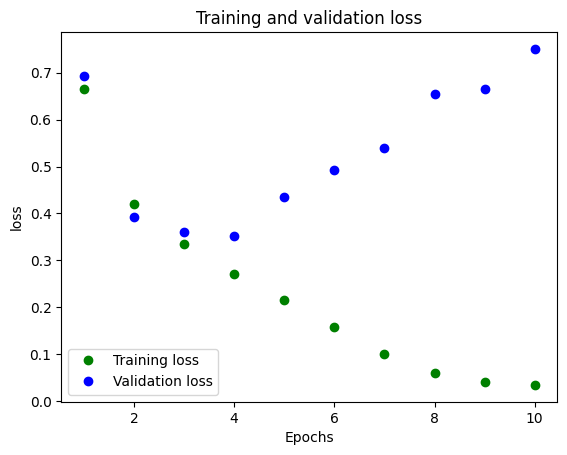

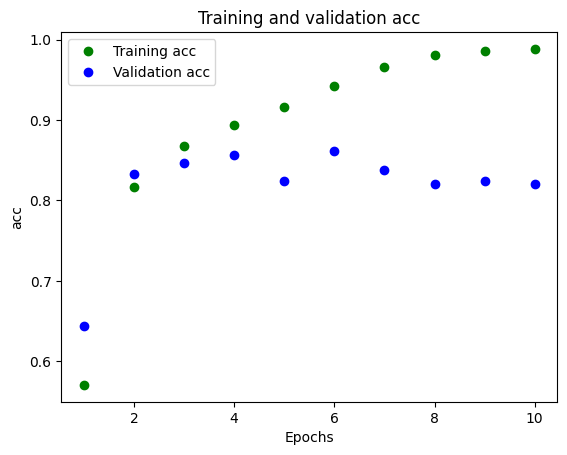

In [26]:
# Display the loss and accuracy curves on a plot:
fit_1_default_dict = model_1_default.history.history
fit_1_default_dict.keys()

plot_metric(fit_1_default_dict, 'loss')
plot_metric(fit_1_default_dict, 'acc')

In [28]:
# model with one SimpleRNN layer
model_0 = Sequential()
model_0.add(Embedding(10000, 32))
model_0.add(SimpleRNN(32))
model_0.add(Dense(1, activation='sigmoid'))
model_0.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Compile - default optimizer 'rmsprop'
model_0.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])

In [30]:
# Train
model_0.fit(input_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/10
157/157 [==============================] - 7s 43ms/step - loss: 0.5705 - acc: 0.7030 - val_loss: 0.5054 - val_acc: 0.7486
Epoch 2/10
157/157 [==============================] - 7s 42ms/step - loss: 0.3715 - acc: 0.8490 - val_loss: 0.4037 - val_acc: 0.8328
Epoch 3/10
157/157 [==============================] - 7s 41ms/step - loss: 0.3173 - acc: 0.8751 - val_loss: 0.4090 - val_acc: 0.8136
Epoch 4/10
157/157 [==============================] - 6s 41ms/step - loss: 0.2488 - acc: 0.9050 - val_loss: 0.3400 - val_acc: 0.8598
Epoch 5/10
157/157 [==============================] - 7s 42ms/step - loss: 0.2092 - acc: 0.9208 - val_loss: 0.4369 - val_acc: 0.8214
Epoch 6/10
157/157 [==============================] - 6s 41ms/step - loss: 0.1647 - acc: 0.9399 - val_loss: 0.4147 - val_acc: 0.8286
Epoch 7/10
157/157 [==============================] - 6s 41ms/step - loss: 0.1275 - acc: 0.9560 - val_loss: 0.4073 - val_acc: 0.8512
Epoch 8/10
157/157 [==============================] - 6s 40ms/step - 

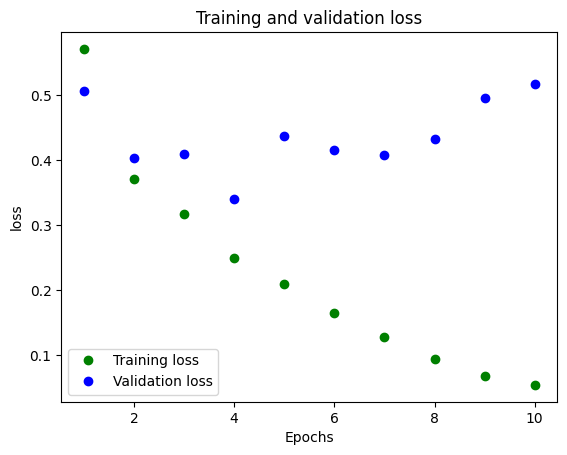

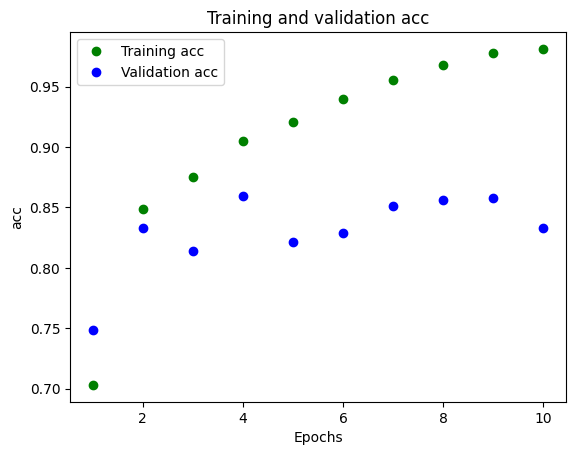

In [31]:
# Plot the loss and accuracy curves for training and validation
fit_0_dict = model_0.history.history
fit_0_dict.keys()

plot_metric(fit_0_dict, 'loss')
plot_metric(fit_0_dict, 'acc')

## LSTM layers
**Long Short-Term Memory (LSTM)** networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present:

![LSTM](images/lesson_9_lstm.jpg)

**Task 2:** Now let's set up a model using a LSTM layer and train it on the IMDB data. The network will be similar to the one with SimpleRNN that you just implemented. We only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults.

Architecture:
- Embedding layer - 10000, 32
- LSTM - 32
- Dense layer with one output and sigmoid activation

Compile:
- optimizer='rmsprop',
- loss='binary_crossentropy',
- metrics=['acc'].

Train:
- epochs=10,
- batch_size=128,
- validation_split=0.2

In [19]:
# Architecture:
# - Embedding layer - 10000, 32
# - LSTM - 32
# - Dense layer with one output and sigmoid activation

from tensorflow.keras.layers import LSTM

model_2 = Sequential()
model_2.add(Embedding(10000, 32))
model_2.add(LSTM(32))
model_2.add(Dense(1, activation='sigmoid'))
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Compile:
# - optimizer='rmsprop',
# - loss='binary_crossentropy',
# - metrics=['acc'].

model_2.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])

In [21]:
# Train:
# - epochs=10,
# - batch_size=128,
# - validation_split=0.2

epochs = 10
batch_size = 128
validation_split = 0.2

model_2.fit(input_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/10
157/157 [==============================] - 14s 83ms/step - loss: 0.6929 - acc: 0.5094 - val_loss: 0.6925 - val_acc: 0.5368
Epoch 2/10
157/157 [==============================] - 13s 81ms/step - loss: 0.6920 - acc: 0.5627 - val_loss: 0.6915 - val_acc: 0.5650
Epoch 3/10
157/157 [==============================] - 13s 81ms/step - loss: 0.6906 - acc: 0.5910 - val_loss: 0.6898 - val_acc: 0.5856
Epoch 4/10
157/157 [==============================] - 13s 80ms/step - loss: 0.6877 - acc: 0.6121 - val_loss: 0.6855 - val_acc: 0.6188
Epoch 5/10
157/157 [==============================] - 13s 82ms/step - loss: 0.6753 - acc: 0.6607 - val_loss: 0.6414 - val_acc: 0.6962
Epoch 6/10
157/157 [==============================] - 13s 82ms/step - loss: 0.5833 - acc: 0.7328 - val_loss: 0.5398 - val_acc: 0.7708
Epoch 7/10
157/157 [==============================] - 13s 82ms/step - loss: 0.5208 - acc: 0.7796 - val_loss: 0.4903 - val_acc: 0.8028
Epoch 8/10
157/157 [==============================] - 13s 83ms

Plot the training and validation loss and accuracy and compare them with SimpleRNN:

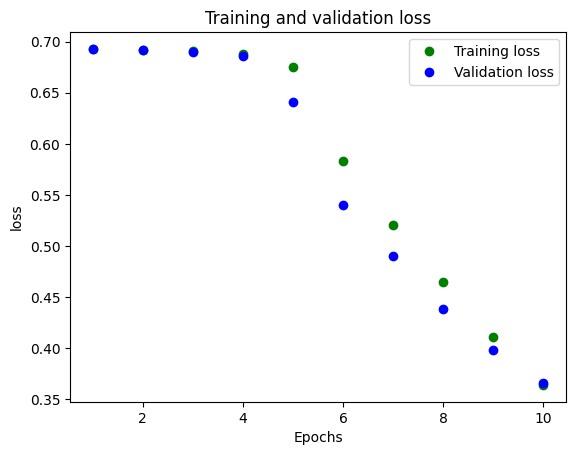

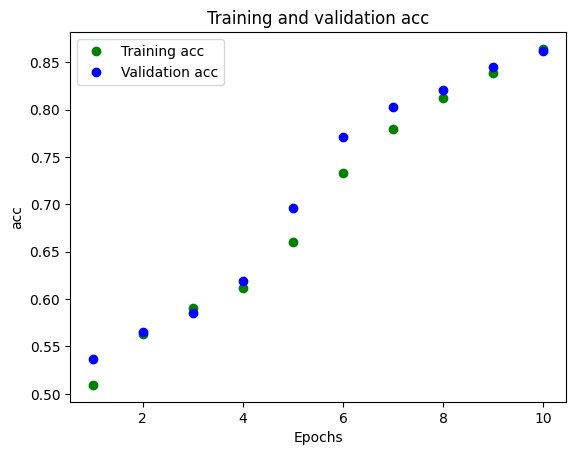

In [22]:
fit_2_dict = model_2.history.history
fit_2_dict.keys()

# Display the loss and accuracy curves on a plot:
plot_metric(fit_2_dict, 'loss')
plot_metric(fit_2_dict, 'acc')